In [1]:
# setup notebook for inline figures
%matplotlib inline
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from code.plot_utils import plot_pretty
plot_pretty()
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

Question #1:
For a and b, I've used the $M_*$ relation for detections only parameters in Table 3. i.e. $log(M_{H2}/M_*) = -0.202(log(M_*)-10.70)-1.3$

[  9.12851042  11.05036017  10.84706893 ...,   9.98784677   5.7650353
   9.57088001] [  9.9700777    9.14406725  10.48239398 ...,          nan          nan
  10.9951374 ]


/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: invalid value encountered in log10
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:43: RuntimeWarning: invalid value encountered in log10
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:51: RuntimeWarning: invalid value encountered in log10


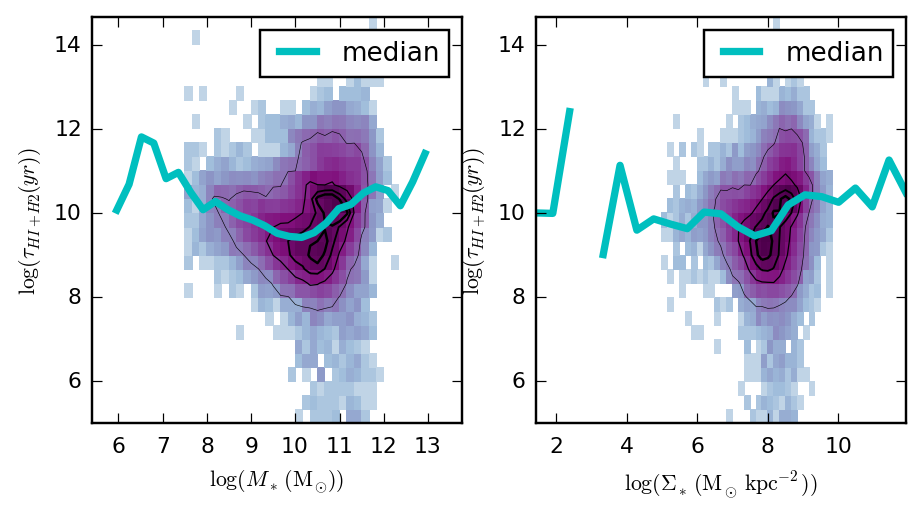

In [15]:
from code.setup import setup
from code.plot_utils import plot_2d_dist, compute_inverse_Vmax
from colossus.cosmology import cosmology

def read_GAMA(fname):
    import pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)
    
data = read_GAMA(setup.data_home_dir()+"GAMA_DR2_full.fits")

cosmo = cosmology.setCosmology('WMAP9')

z_min = 0.001; z_max = 1.0
m_min = 10.5; m_max = 19.0
mpetro = data['PETROMAG_R'] - data['EXTINCTION_R']

data = data[(mpetro > m_min) & (mpetro < m_max)]; 
data = data[data['Z_HELIO'] > z_min];   
data = data[data['Z_HELIO'] < z_max]

mpetro = data['PETROMAG_R'] - data['EXTINCTION_R']
zg = data['Z_TONRY']

vmaxim = compute_inverse_Vmax(mpetro, zg, m_min=m_min, m_max=m_max, cosmomodel='WMAP9')
vmaxim = vmaxim / np.sum(vmaxim)
lMstar = data['logmstar']
Mstar = np.power(10.,lMstar)
r50 = data['GAL_RE_R']
r90 = data['GAL_R90_R']
sfr = data['SFR']
lsfr = np.log10(sfr)
# metallicity
Z = data['metal']/0.0126 # normalize to solar according to Asplund et al. (2004)
lZ = np.log10(Z)

#getting the H2 mass from the molecular fraction
logMH2 = lMstar + (-0.202)*(lMstar-10.70) - 1.3
logH2toHI = (lMstar-10.7)*0.425 - 0.387
logMHI = logMH2-logH2toHI
MHIandH2 = 10.**(logMH2) + 10.**(logMHI)
tauHIH2 = MHIandH2/sfr
ltau = np.log10(tauHIH2)

# compute angular diameter distances
d_A = cosmo.luminosityDistance(zg)/cosmo.h/(1.+zg)
r50 = r50*np.pi*d_A*1000.0/(180.*3600.)
# SFR -> SFR/kpc^2, M*->Sigma_* in Msun/kpc^2
ssfr = sfr/(np.pi*r50**2)
smstar = 0.5*Mstar/(np.pi*r50**2)
lssfr = np.log10(ssfr); lsmstar = np.log10(smstar)

#
# plot SFR-M*
#

fig,ax = plt.subplots(1,2,figsize=(6, 3))
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(\tau_{HI+H2} (yr))$')

clevs = np.linspace(0.2,0.95,4)
MHIH2lim = [7.5, 12.5]; taulim = [5., 15.]
xlabel='Stellar Mass'
ylabel='Time of Gas Consumption'
plot_2d_dist(x=lMstar, y=ltau, xlim=MHIH2lim, ylim=taulim, xlabel=xlabel, ylabel=ylabel, 
             weights=None, nxbins=31, nybins=31, clevs=clevs, fig_setup=ax[0])

# now the same in the form of surface densities 
indices = np.isfinite(ltau)
#
from scipy.stats import binned_statistic
print lMstar, ltau
cmedx, ibedgesx, babinsx = binned_statistic(lMstar[indices],ltau[indices],statistic='median',bins=31)
ibinsx = 0.5*(ibedgesx[1:] + ibedgesx[:-1])
ax[0].plot(ibinsx,cmedx,c='c',lw=3.0, label='median')
ax[0].legend(loc='best')
ax[1].set_xlabel(r'$\log(\Sigma_*\ \mathrm{(M_{\odot}\,kpc^{-2})})$')
ax[1].set_ylabel(r'$\log(\tau_{HI+H2} (yr))$')
#ax[1].set_ylabel(r'$\Sigma_{\rm SFR}\ \mathrm{(M_\odot\,yr^{-1}\, kpc^{-2})}$')

plot_2d_dist(x=lsmstar, y=ltau, xlim=[5.0, 10.0], ylim=taulim, xlabel=xlabel, ylabel=ylabel, 
             weights=None, nxbins=31, nybins=31, clevs=clevs, fig_setup=ax[1])
from scipy.stats import binned_statistic
cmedb, ibedgesb, babinsb = binned_statistic(lsmstar[indices],ltau[indices],statistic='median',bins=31)
ibinsb = 0.5*(ibedgesb[1:] + ibedgesb[:-1])
ax[1].plot(ibinsb[3:-4],cmedb[3:-4],c='c',lw=3.0, label='median')
ax[1].legend(loc='best')
#plot_2d_dist(lsmstar, ltau, xlim, ylim,nxbins,nybins, log=True, weights=None, xlabel='x',ylabel='y', 
#                 clevs=clevs, smooth=[3,2], fig_setup=ax[1], savefig=None)

# plot linear power law relation
#x = np.linspace(6.5,9.5,50)
#sfrlin = -1.6 + (x-8.)
#ax[1].plot(10.**x, 10.**sfrlin,'--',c='c', lw=1.5, label=r'$\dot{M}_*\propto M_*$')

#sfrpow = -1.5 + 1.5*(x-8.)
#ax[1].plot(10.**x, 10.**sfrpow,'--',c='b', lw=1.5, label=r'$\dot{M}_*\propto M_*^{1.5}$')
plt.show()

For the plots above, you can disregard the median where it does not overlap with the 2D distribution (had some probleems in setting limits in the plot). Compared to the equation, the typical gas depletion time seems quite reasonable. The relation implies a time of about ~$1\times 10^{9}$ years, which is more or less what we see, although the surface  density plot seem to have a distribution slightly higher than that. 

/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in log10
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:42: RuntimeWarning: invalid value encountered in log10


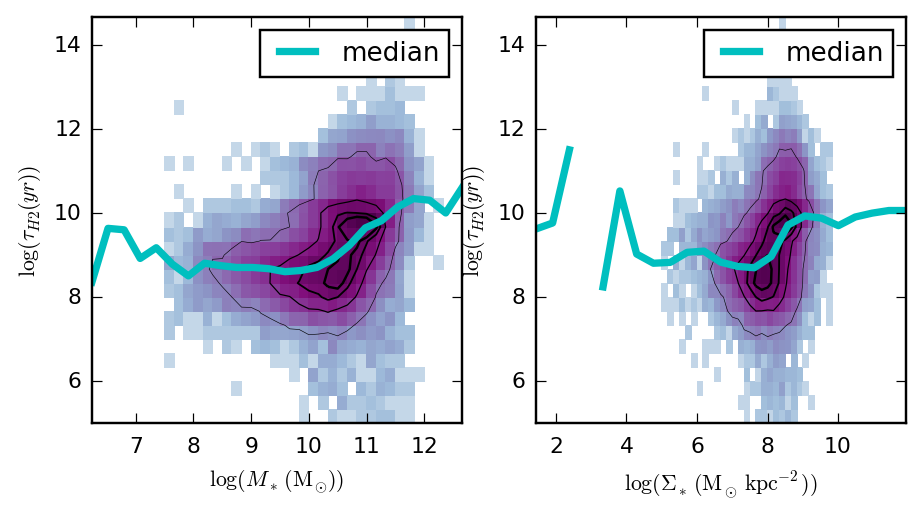

In [16]:
data = read_GAMA(setup.data_home_dir()+"GAMA_DR2_full.fits")

cosmo = cosmology.setCosmology('WMAP9')

z_min = 0.001; z_max = 0.6
m_min = 10.5; m_max = 19.0
mpetro = data['PETROMAG_R'] - data['EXTINCTION_R']

data = data[(mpetro > m_min) & (mpetro < m_max)]; 
data = data[data['Z_HELIO'] > z_min];   
data = data[data['Z_HELIO'] < z_max]

mpetro = data['PETROMAG_R'] - data['EXTINCTION_R']
zg = data['Z_TONRY']

vmaxim = compute_inverse_Vmax(mpetro, zg, m_min=m_min, m_max=m_max, cosmomodel='WMAP9')
vmaxim = vmaxim / np.sum(vmaxim)
lMstar = data['logmstar']
Mstar = np.power(10.,lMstar)
r50 = data['GAL_RE_R']
r90 = data['GAL_R90_R']
sfr = data['SFR']
lsfr = np.log10(sfr)
# metallicity
Z = data['metal']/0.0126 # normalize to solar according to Asplund et al. (2004)
lZ = np.log10(Z)

#getting the H2 mass from the molecular fraction
logMH2 = lMstar + (-0.202)*(lMstar-10.70) - 1.3
logH2toHI = 0.3
logMHI = logMH2-logH2toHI
MHIandH2 = 10.**(logMH2) + 10.**(logMHI)
tauH2 = 10**(logMH2)/sfr
ltau2 = np.log10(tauH2)

# compute angular diameter distances
d_A = cosmo.luminosityDistance(zg)/cosmo.h/(1.+zg)
r50 = r50*np.pi*d_A*1000.0/(180.*3600.)
# SFR -> SFR/kpc^2, M*->Sigma_* in Msun/kpc^2
ssfr = sfr/(np.pi*r50**2)
smstar = 0.5*Mstar/(np.pi*r50**2)
lssfr = np.log10(ssfr); lsmstar = np.log10(smstar)
indices2 = np.isfinite(ltau2)

fig,ax = plt.subplots(1,2,figsize=(6, 3))
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(\tau_{H2} (yr))$')

clevs = np.linspace(0.2,0.95,4)
MHIH2lim = [7.5, 12.5]; taulim = [5., 15.]
xlabel='Stellar Mass'
ylabel='Time of Gas Consumption'
plot_2d_dist(x=lMstar, y=ltau2, xlim=MHIH2lim, ylim=taulim, xlabel=xlabel, ylabel=ylabel, 
             weights=None, nxbins=31, nybins=31, clevs=clevs, fig_setup=ax[0])
from scipy.stats import binned_statistic
cmedc, ibedgesc, babinsc = binned_statistic(lMstar[indices2],ltau2[indices2],statistic='median',bins=31)
ibinsc = 0.5*(ibedgesc[1:] + ibedgesc[:-1])
ax[0].plot(ibinsc[3:-4],cmedc[3:-4],c='c',lw=3.0, label='median')
ax[0].legend(loc='best')
# now the same in the form of surface densities 
#

ax[1].set_xlabel(r'$\log(\Sigma_*\ \mathrm{(M_{\odot}\,kpc^{-2})})$')
ax[1].set_ylabel(r'$\log(\tau_{H2} (yr))$')
#ax[1].set_ylabel(r'$\Sigma_{\rm SFR}\ \mathrm{(M_\odot\,yr^{-1}\, kpc^{-2})}$')

plot_2d_dist(x=lsmstar, y=ltau2, xlim=[5.0, 10.0], ylim=taulim, xlabel=xlabel, ylabel=ylabel, 
             weights=None, nxbins=31, nybins=31, clevs=clevs, fig_setup=ax[1])
from scipy.stats import binned_statistic
cmedc, ibedgesc, babinsc = binned_statistic(lsmstar[indices2],ltau2[indices2],statistic='median',bins=31)
ibinsc = 0.5*(ibedgesc[1:] + ibedgesc[:-1])
ax[1].plot(ibinsc[3:-4],cmedc[3:-4],c='c',lw=3.0, label='median')
ax[1].legend(loc='best')

Again, please ignore the median for the parts that do not overlap with the distribution. The timescale seems to have gone down by an order of magnitude from the previous plot, again, it's quite comparable to the typical gas depletion time described by Kennicut 1998.

Question #2

In [17]:
import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph, stuff, stuff2 = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005;
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];
#
Rhl = mdata['r_tot']

# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2) & (Rhl > 2.0)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']
Rhl = mdata['r_tot']
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd'];

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print "selected", np.size(zm), " after all cuts..."

# inverse Vmax
vmaxi = 1.0/vmaxm[ilim] 
# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h
d_A = cosmo.luminosityDistance(zm)/cosmo.h/(1.+zm)
Rhl_kpc = Rhl*np.pi*d_A*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); Lpetrom = 0.4*(4.67-Mpetrom)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell = -.306 + 1.097*grm - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert = Lmeert + lMsLrbell

670722 galaxies in Meert et al. sample initially
selected 201582  after all cuts...


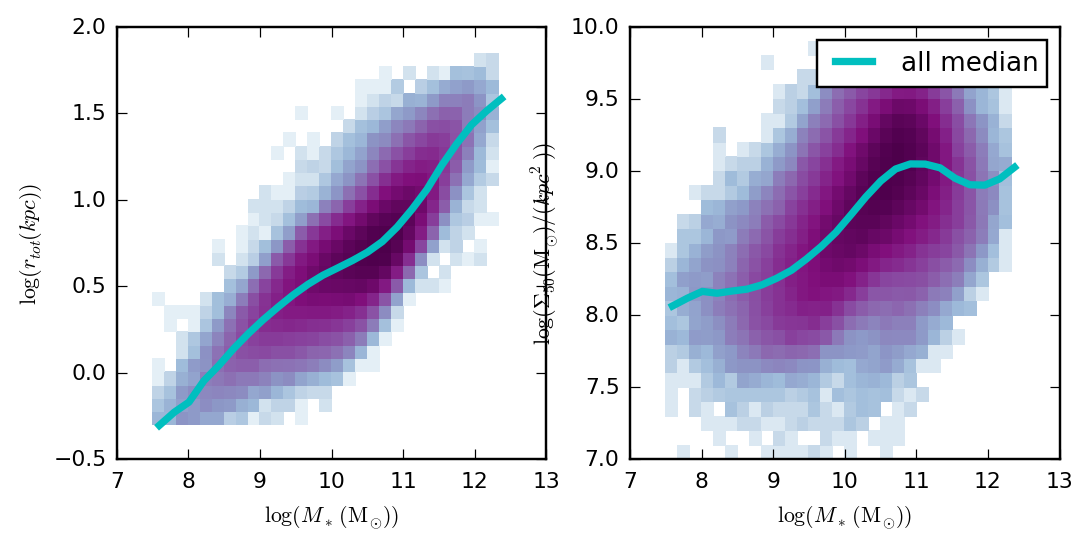

In [18]:
StellarMass = 10.**SMmeert*cosmo.h**2
SMlim = [7.5, 12.5]
Rhllim = [-0.3, 2]
from code.plot_utils import plot_2d_dist
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)
plt.clf()

fig, ax = plt.subplots(1,2,figsize=(6,3))
fig.tight_layout()

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]

plot_2d_dist(np.log10(StellarMass), np.log10(Rhl_kpc), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[0])
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed, ibedges, babins = binned_statistic(np.log10(StellarMass),np.log10(Rhl_kpc),statistic='median',bins=31)
ibins = 0.5*(ibedges[1:] + ibedges[:-1])
ax[0].plot(ibins[3:-4],cmed[3:-4],c='c',lw=3.0)
#ax.semilogy()


#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]

plot_2d_dist(np.log10(StellarMass), np.log10(10**SMmeert/(np.pi*Rhl_kpc**2)), SMlim, [7,10], weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[1])
ax[1].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[1].set_ylabel(r'$\log(\Sigma_{50} \mathrm{(M_{\odot})}/(kpc^2))$')
from scipy.stats import binned_statistic
cmeda, ibedgesa, babinsa = binned_statistic(np.log10(StellarMass),np.log10(10**SMmeert/(np.pi*Rhl_kpc**2)),statistic='median',bins=31)
ibinsa = 0.5*(ibedgesa[1:] + ibedgesa[:-1])
ax[1].plot(ibinsa[3:-4],cmeda[3:-4],c='c',lw=3.0, label='all median')
ax[1].legend(loc='best')

#ax.semilogy()
plt.show()
#plt.plot(StellarMass,Rhl_kpc, '.')
#plt.semilogx()

The second plot is for the comparison with all the galaxies in part d of this question. The main plot for a is on the left.

selected 4093  after all cuts...
selected

/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:47: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582


 4214  after all cuts...
selected 2191  after all cuts...
selected

/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:79: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:111: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582


 2533  after all cuts...


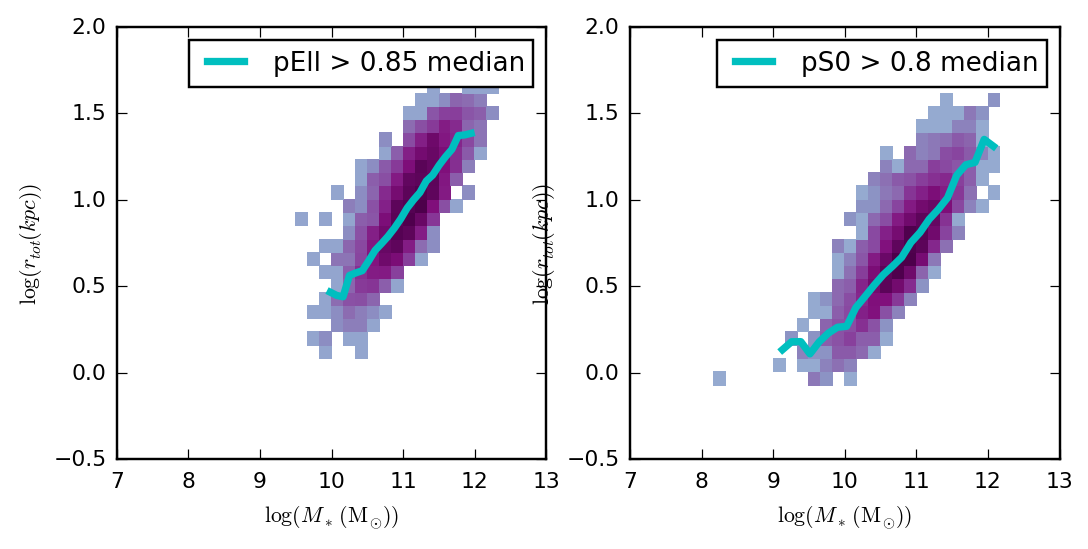

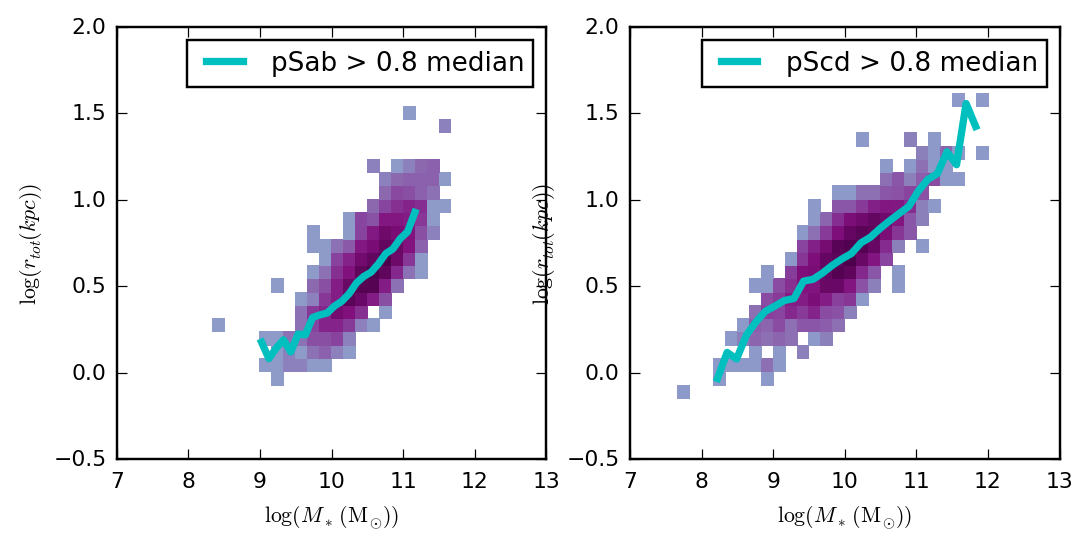

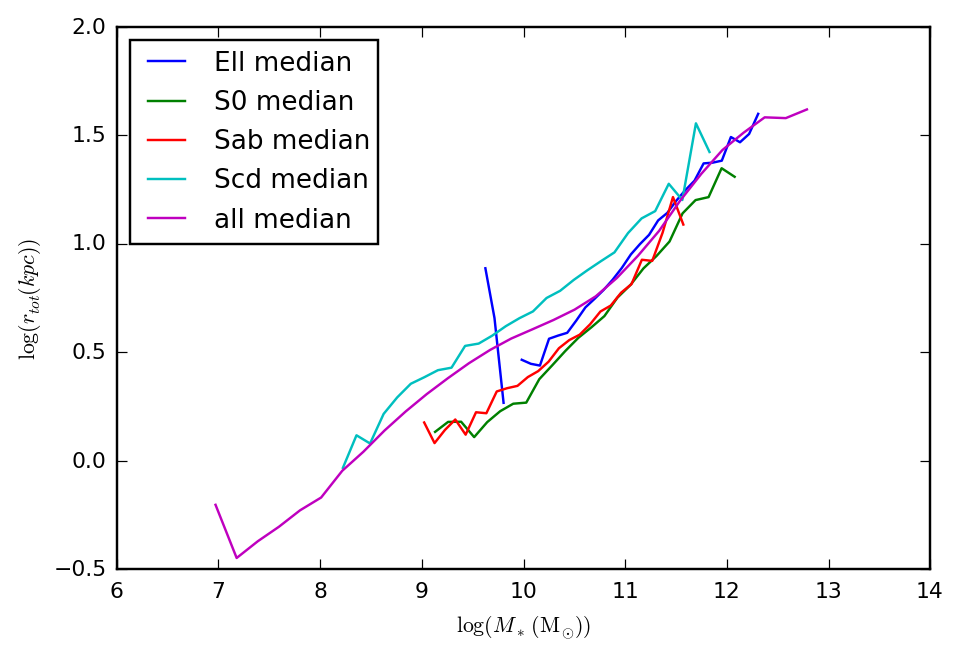

In [30]:
# make some cuts to eliminate bad regimes or catastrophic failures
ipEll = ((pEll>0.85) & (pS0<0.5) & (pSab<0.2) & (pScd<0.2))

# select data within these cuts
sdata1 = sdata[ipEll]; mdata1 = mdata[ipEll]; phot_r1 = phot_r[ipEll] 
mnpdata1 = mnpdata[ipEll]; grm1 = grm[ipEll]; morph1 = morph[ipEll]
mdatag1 = mdatag[ipEll]; mnpdatag1 = mnpdatag[ipEll]
zm1 = sdata1['z']; mpetrom1 = phot_r1['petroMag']; mmeert1 = mdata1['m_tot']
sb501 = sb50[ipEll]; extm1 = mnpdata1['extinction']; kcorr1 = mnpdata1['kcorr']
Rhl1 = mdata1['r_tot']

print "selected", np.size(zm1), " after all cuts..."

# inverse Vmax
vmaxi1 = 1.0/vmaxm[ipEll] 
# luminosity distance in Mpc
d_Lm1 = cosmo.luminosityDistance(zm1)/cosmo.h
d_A1 = cosmo.luminosityDistance(zm1)/cosmo.h/(1.+zm1)
Rhl_kpc1 = Rhl1*np.pi*d_A1*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert1 = mmeert1 - 5.0*np.log10(d_Lm1/1e-5) - extm1 + 1.3*zm1 - kcorr1; 
Mpetrom1 = mpetrom1 - 5.0*np.log10(d_Lm1/1e-5) - extm1 + 1.3*zm1 - kcorr1;

# 4.67 is the r-band luminosity in Lsun
Lmeert1 =  0.4*(4.67-(Mmeert1)); Lpetrom1 = 0.4*(4.67-Mpetrom1)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell1 = -.306 + 1.097*grm1 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert1 = Lmeert1 + lMsLrbell1
StellarMass1 = 10.**SMmeert1*cosmo.h**2

# make some cuts to eliminate bad regimes or catastrophic failures
ipS0 = ((pEll<0.5) & (pS0>0.8) & (pSab<0.2) & (pScd<0.2))

# select data within these cuts
sdata2 = sdata[ipS0]; mdata2 = mdata[ipS0]; phot_r2 = phot_r[ipS0] 
mnpdata2 = mnpdata[ipS0]; grm2 = grm[ipS0]; morph2 = morph[ipS0]
mdatag2 = mdatag[ipS0]; mnpdatag2 = mnpdatag[ipS0]
zm2 = sdata2['z']; mpetrom2 = phot_r2['petroMag']; mmeert2 = mdata2['m_tot']
sb502 = sb50[ipS0]; extm2 = mnpdata2['extinction']; kcorr2 = mnpdata2['kcorr']
Rhl2 = mdata2['r_tot']

print "selected", np.size(zm2), " after all cuts..."

# inverse Vmax
vmaxi2 = 1.0/vmaxm[ipS0] 
# luminosity distance in Mpc
d_Lm2 = cosmo.luminosityDistance(zm2)/cosmo.h
d_A2 = cosmo.luminosityDistance(zm2)/cosmo.h/(1.+zm2)
Rhl_kpc2 = Rhl2*np.pi*d_A2*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert2 = mmeert2 - 5.0*np.log10(d_Lm2/1e-5) - extm2 + 1.3*zm2 - kcorr2; 
Mpetrom2 = mpetrom2 - 5.0*np.log10(d_Lm2/1e-5) - extm2 + 1.3*zm2 - kcorr2;

# 4.67 is the r-band luminosity in Lsun
Lmeert2 =  0.4*(4.67-(Mmeert2)); Lpetrom2 = 0.4*(4.67-Mpetrom2)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell2 = -.306 + 1.097*grm2 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert2 = Lmeert2 + lMsLrbell2
StellarMass2 = 10.**SMmeert2*cosmo.h**2

# make some cuts to eliminate bad regimes or catastrophic failures
ipSab = ((pEll<0.2) & (pS0<0.2) & (pSab>0.8) & (pScd<0.5))

# select data within these cuts
sdata3 = sdata[ipSab]; mdata3 = mdata[ipSab]; phot_r3 = phot_r[ipSab] 
mnpdata3 = mnpdata[ipSab]; grm3 = grm[ipSab]; morph3 = morph[ipSab]
mdatag3 = mdatag[ipSab]; mnpdatag3 = mnpdatag[ipSab]
zm3 = sdata3['z']; mpetrom3 = phot_r3['petroMag']; mmeert3 = mdata3['m_tot']
sb503 = sb50[ipSab]; extm3 = mnpdata3['extinction']; kcorr3 = mnpdata3['kcorr']
Rhl3 = mdata3['r_tot']

print "selected", np.size(zm3), " after all cuts..."

# inverse Vmax
vmaxi3 = 1.0/vmaxm[ipSab] 
# luminosity distance in Mpc
d_Lm3 = cosmo.luminosityDistance(zm3)/cosmo.h
d_A3 = cosmo.luminosityDistance(zm3)/cosmo.h/(1.+zm3)
Rhl_kpc3 = Rhl3*np.pi*d_A3*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert3 = mmeert3 - 5.0*np.log10(d_Lm3/1e-5) - extm3 + 1.3*zm3 - kcorr3; 
Mpetrom3 = mpetrom3 - 5.0*np.log10(d_Lm3/1e-5) - extm3 + 1.3*zm3 - kcorr3;

# 4.67 is the r-band luminosity in Lsun
Lmeert3 =  0.4*(4.67-(Mmeert3)); Lpetrom3 = 0.4*(4.67-Mpetrom3)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell3 = -.306 + 1.097*grm3 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert3 = Lmeert3 + lMsLrbell3
StellarMass3 = 10.**SMmeert3*cosmo.h**2

# make some cuts to eliminate bad regimes or catastrophic failures
ipScd = ((pEll<0.2) & (pS0<0.2) & (pSab<0.5) & (pScd>0.8))

# select data within these cuts
sdata4 = sdata[ipScd]; mdata4 = mdata[ipScd]; phot_r4 = phot_r[ipScd] 
mnpdata4 = mnpdata[ipScd]; grm4 = grm[ipScd]; morph4 = morph[ipScd]
mdatag4 = mdatag[ipScd]; mnpdatag4 = mnpdatag[ipScd]
zm4 = sdata4['z']; mpetrom4 = phot_r4['petroMag']; mmeert4 = mdata4['m_tot']
sb504 = sb50[ipScd]; extm4 = mnpdata4['extinction']; kcorr4 = mnpdata4['kcorr']
Rhl4 = mdata4['r_tot']

print "selected", np.size(zm4), " after all cuts..."

# inverse Vmax
vmaxi4 = 1.0/vmaxm[ipScd] 
# luminosity distance in Mpc
d_Lm4 = cosmo.luminosityDistance(zm4)/cosmo.h
d_A4 = cosmo.luminosityDistance(zm4)/cosmo.h/(1.+zm4)
Rhl_kpc4 = Rhl4*np.pi*d_A4*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert4 = mmeert4 - 5.0*np.log10(d_Lm4/1e-5) - extm4 + 1.3*zm4 - kcorr4; 
Mpetrom4 = mpetrom4 - 5.0*np.log10(d_Lm4/1e-5) - extm4 + 1.3*zm4 - kcorr4;

# 4.67 is the r-band luminosity in Lsun
Lmeert4 =  0.4*(4.67-(Mmeert4)); Lpetrom4 = 0.4*(4.67-Mpetrom4)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell4 = -.306 + 1.097*grm4 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert4 = Lmeert4 + lMsLrbell4
StellarMass4 = 10.**SMmeert4*cosmo.h**2

fig,ax = plt.subplots(1,2,figsize=(6, 3))
fig.tight_layout()

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]

plot_2d_dist(np.log10(StellarMass1), np.log10(Rhl_kpc1), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[0])
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed1, ibedges1, babins1 = binned_statistic(np.log10(StellarMass1),np.log10(Rhl_kpc1),statistic='median',bins=31)
ibins1 = 0.5*(ibedges1[1:] + ibedges1[:-1])
ax[0].plot(ibins1[3:-4],cmed1[3:-4],c='c',lw=3.0, label = 'pEll > 0.85 median')
ax[0].legend(loc='best')


plot_2d_dist(np.log10(StellarMass2), np.log10(Rhl_kpc2), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[1])
ax[1].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[1].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed2, ibedges2, babins2 = binned_statistic(np.log10(StellarMass2),np.log10(Rhl_kpc2),statistic='median',bins=31)
ibins2 = 0.5*(ibedges2[1:] + ibedges2[:-1])
ax[1].plot(ibins2[3:],cmed2[3:],c='c',lw=3.0, label = 'pS0 > 0.8 median')
ax[1].legend(loc='best')
#ax.semilogy()
plt.show()

fig,ax = plt.subplots(1,2,figsize=(6, 3))
fig.tight_layout()

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]

plot_2d_dist(np.log10(StellarMass3), np.log10(Rhl_kpc3), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[0])
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed3, ibedges3, babins3 = binned_statistic(np.log10(StellarMass3),np.log10(Rhl_kpc3),statistic='median',bins=31)
ibins3 = 0.5*(ibedges3[1:] + ibedges3[:-1])
ax[0].plot(ibins3[3:-4],cmed3[3:-4],c='c',lw=3.0, label = 'pSab > 0.8 median')
ax[0].legend(loc='best')


plot_2d_dist(np.log10(StellarMass4), np.log10(Rhl_kpc4), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[1])
ax[1].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[1].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed4, ibedges4, babins4 = binned_statistic(np.log10(StellarMass4),np.log10(Rhl_kpc4),statistic='median',bins=31)
ibins4 = 0.5*(ibedges4[1:] + ibedges4[:-1])
ax[1].plot(ibins4[3:],cmed4[3:],c='c',lw=3.0, label = 'pScd > 0.8 median')
ax[1].legend(loc='best')
#ax.semilogy()
plt.show()
plt.xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
plt.ylabel(r'$\log(r_{tot} (kpc))$')
plt.plot(ibins1, cmed1, label='Ell median')
plt.plot(ibins2, cmed2, label='S0 median')
plt.plot(ibins3, cmed3, label='Sab median')
plt.plot(ibins4, cmed4, label='Scd median')
plt.plot(ibins,cmed,label='all median')
plt.legend(loc='best')
plt.show()

Since there is much more elliptical galaxies than the other types, I made a stricter cut on the elliptical galaxies to have a more fair sample size. Over all, I see that the late type galaxies tend to have a  larger half-light radius than early type galaxies as a function of stellar mass. We do see that there is an over all upward trend, more massive galaxies have larger radii. This makes sense intuitively. For the distribution, the early type galaxies are more massive than the late type galaxies. In particular, the elliptical galaxies have larger radii than lenticular galaxies. On the other hand, late type disk galaxies (Scd) seem to have larger radii than early type disk galaxies (Sab) at the same stellar mass. 

c) For disk galaxies, they are disk-shaped. So we can approximate 3D half-light radius as the 2D half-light radius. i.e. $r_{50, 3D} = r_{50, 2D}$. For elliptical, approximating them as spheroids, the 3D half-light radius can be obtained as $r_{50, 3D} = 1.34*r_{50, 2D}$ where $r_{50, 2D}$ is the projected half light radius for spheroidal galaxies (I used the results of this paper: http://arxiv.org/pdf/astro-ph/9905048v1.pdf). 

selected 4093  after all cuts...
selected

/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:48: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582


 4214  after all cuts...
selected 2191  after all cuts...
selected

/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:81: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:113: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582


 2533  after all cuts...


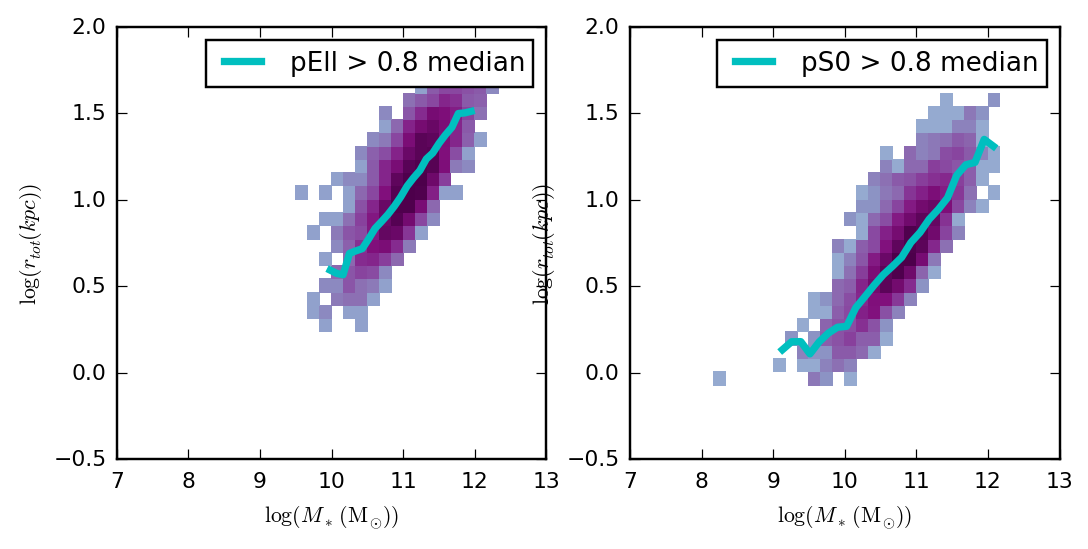

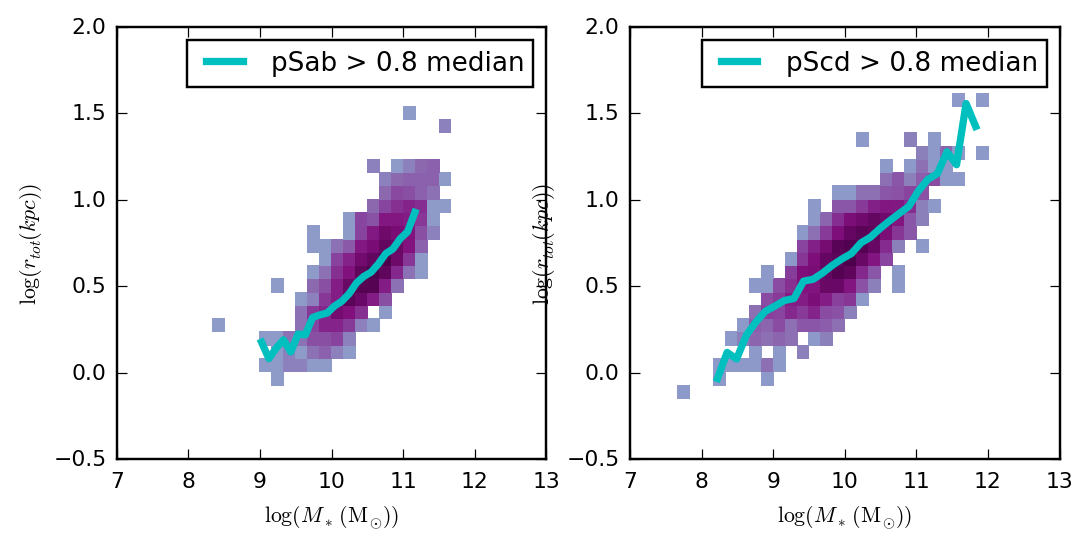

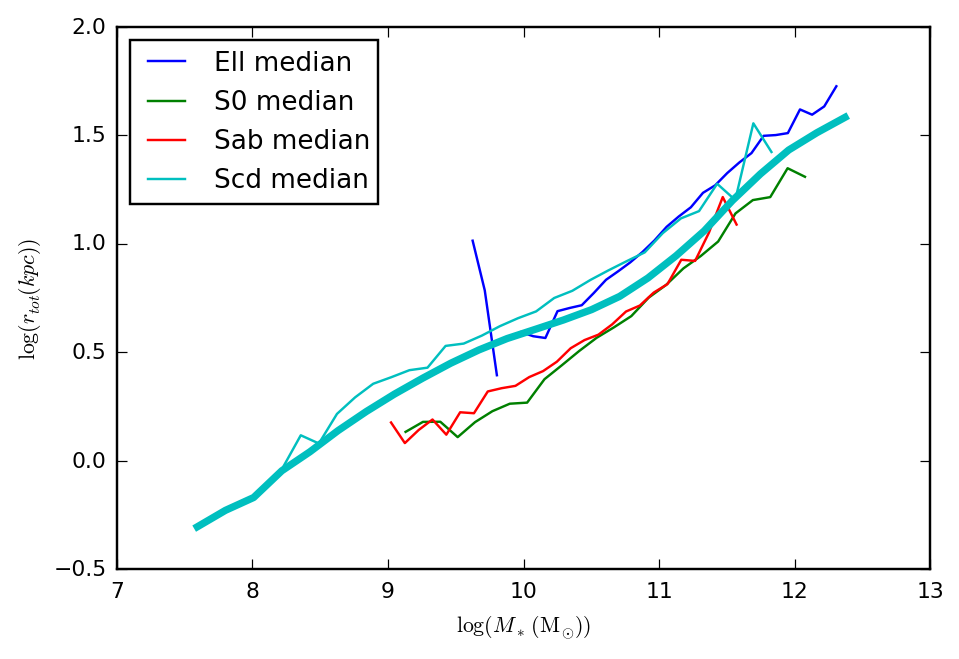

In [31]:
# make some cuts to eliminate bad regimes or catastrophic failures
ipEll = ((pEll>0.85) & (pS0<0.5) & (pSab<0.2) & (pScd<0.2))

# select data within these cuts
sdata1 = sdata[ipEll]; mdata1 = mdata[ipEll]; phot_r1 = phot_r[ipEll] 
mnpdata1 = mnpdata[ipEll]; grm1 = grm[ipEll]; morph1 = morph[ipEll]
mdatag1 = mdatag[ipEll]; mnpdatag1 = mnpdatag[ipEll]
zm1 = sdata1['z']; mpetrom1 = phot_r1['petroMag']; mmeert1 = mdata1['m_tot']
sb501 = sb50[ipEll]; extm1 = mnpdata1['extinction']; kcorr1 = mnpdata1['kcorr']
Rhl1 = mdata1['r_tot']

print "selected", np.size(zm1), " after all cuts..."

# inverse Vmax
vmaxi1 = 1.0/vmaxm[ipEll] 
# luminosity distance in Mpc
d_Lm1 = cosmo.luminosityDistance(zm1)/cosmo.h
d_A1 = cosmo.luminosityDistance(zm1)/cosmo.h/(1.+zm1)
Rhl_kpc1_orig = Rhl1*np.pi*d_A1*1000.0/(180.*3600.)
Rhl_kpc1 = Rhl_kpc1_orig*1.34

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert1 = mmeert1 - 5.0*np.log10(d_Lm1/1e-5) - extm1 + 1.3*zm1 - kcorr1; 
Mpetrom1 = mpetrom1 - 5.0*np.log10(d_Lm1/1e-5) - extm1 + 1.3*zm1 - kcorr1;

# 4.67 is the r-band luminosity in Lsun
Lmeert1 =  0.4*(4.67-(Mmeert1)); Lpetrom1 = 0.4*(4.67-Mpetrom1)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell1 = -.306 + 1.097*grm1 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert1 = Lmeert1 + lMsLrbell1
StellarMass1 = 10.**SMmeert1*cosmo.h**2

# make some cuts to eliminate bad regimes or catastrophic failures
ipS0 = ((pEll<0.5) & (pS0>0.8) & (pSab<0.2) & (pScd<0.2))

# select data within these cuts
sdata2 = sdata[ipS0]; mdata2 = mdata[ipS0]; phot_r2 = phot_r[ipS0] 
mnpdata2 = mnpdata[ipS0]; grm2 = grm[ipS0]; morph2 = morph[ipS0]
mdatag2 = mdatag[ipS0]; mnpdatag2 = mnpdatag[ipS0]
zm2 = sdata2['z']; mpetrom2 = phot_r2['petroMag']; mmeert2 = mdata2['m_tot']
sb502 = sb50[ipS0]; extm2 = mnpdata2['extinction']; kcorr2 = mnpdata2['kcorr']
Rhl2 = mdata2['r_tot']

print "selected", np.size(zm2), " after all cuts..."

# inverse Vmax
vmaxi2 = 1.0/vmaxm[ipS0] 
# luminosity distance in Mpc
d_Lm2 = cosmo.luminosityDistance(zm2)/cosmo.h
d_A2 = cosmo.luminosityDistance(zm2)/cosmo.h/(1.+zm2)
Rhl_kpc2_orig = Rhl2*np.pi*d_A2*1000.0/(180.*3600.)
Rhl_kpc2 = Rhl_kpc2_orig

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert2 = mmeert2 - 5.0*np.log10(d_Lm2/1e-5) - extm2 + 1.3*zm2 - kcorr2; 
Mpetrom2 = mpetrom2 - 5.0*np.log10(d_Lm2/1e-5) - extm2 + 1.3*zm2 - kcorr2;

# 4.67 is the r-band luminosity in Lsun
Lmeert2 =  0.4*(4.67-(Mmeert2)); Lpetrom2 = 0.4*(4.67-Mpetrom2)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell2 = -.306 + 1.097*grm2 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert2 = Lmeert2 + lMsLrbell2
StellarMass2 = 10.**SMmeert2*cosmo.h**2

# make some cuts to eliminate bad regimes or catastrophic failures
ipSab = ((pEll<0.2) & (pS0<0.2) & (pSab>0.8) & (pScd<0.5))

# select data within these cuts
sdata3 = sdata[ipSab]; mdata3 = mdata[ipSab]; phot_r3 = phot_r[ipSab] 
mnpdata3 = mnpdata[ipSab]; grm3 = grm[ipSab]; morph3 = morph[ipSab]
mdatag3 = mdatag[ipSab]; mnpdatag3 = mnpdatag[ipSab]
zm3 = sdata3['z']; mpetrom3 = phot_r3['petroMag']; mmeert3 = mdata3['m_tot']
sb503 = sb50[ipSab]; extm3 = mnpdata3['extinction']; kcorr3 = mnpdata3['kcorr']
Rhl3 = mdata3['r_tot']

print "selected", np.size(zm3), " after all cuts..."

# inverse Vmax
vmaxi3 = 1.0/vmaxm[ipSab] 
# luminosity distance in Mpc
d_Lm3 = cosmo.luminosityDistance(zm3)/cosmo.h
d_A3 = cosmo.luminosityDistance(zm3)/cosmo.h/(1.+zm3)
Rhl_kpc3 = Rhl3*np.pi*d_A3*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert3 = mmeert3 - 5.0*np.log10(d_Lm3/1e-5) - extm3 + 1.3*zm3 - kcorr3; 
Mpetrom3 = mpetrom3 - 5.0*np.log10(d_Lm3/1e-5) - extm3 + 1.3*zm3 - kcorr3;

# 4.67 is the r-band luminosity in Lsun
Lmeert3 =  0.4*(4.67-(Mmeert3)); Lpetrom3 = 0.4*(4.67-Mpetrom3)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell3 = -.306 + 1.097*grm3 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert3 = Lmeert3 + lMsLrbell3
StellarMass3 = 10.**SMmeert3*cosmo.h**2

# make some cuts to eliminate bad regimes or catastrophic failures
ipScd = ((pEll<0.2) & (pS0<0.2) & (pSab<0.5) & (pScd>0.8))

# select data within these cuts
sdata4 = sdata[ipScd]; mdata4 = mdata[ipScd]; phot_r4 = phot_r[ipScd] 
mnpdata4 = mnpdata[ipScd]; grm4 = grm[ipScd]; morph4 = morph[ipScd]
mdatag4 = mdatag[ipScd]; mnpdatag4 = mnpdatag[ipScd]
zm4 = sdata4['z']; mpetrom4 = phot_r4['petroMag']; mmeert4 = mdata4['m_tot']
sb504 = sb50[ipScd]; extm4 = mnpdata4['extinction']; kcorr4 = mnpdata4['kcorr']
Rhl4 = mdata4['r_tot']

print "selected", np.size(zm4), " after all cuts..."

# inverse Vmax
vmaxi4 = 1.0/vmaxm[ipScd] 
# luminosity distance in Mpc
d_Lm4 = cosmo.luminosityDistance(zm4)/cosmo.h
d_A4 = cosmo.luminosityDistance(zm4)/cosmo.h/(1.+zm4)
Rhl_kpc4 = Rhl4*np.pi*d_A4*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert4 = mmeert4 - 5.0*np.log10(d_Lm4/1e-5) - extm4 + 1.3*zm4 - kcorr4; 
Mpetrom4 = mpetrom4 - 5.0*np.log10(d_Lm4/1e-5) - extm4 + 1.3*zm4 - kcorr4;

# 4.67 is the r-band luminosity in Lsun
Lmeert4 =  0.4*(4.67-(Mmeert4)); Lpetrom4 = 0.4*(4.67-Mpetrom4)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell4 = -.306 + 1.097*grm4 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert4 = Lmeert4 + lMsLrbell4
StellarMass4 = 10.**SMmeert4*cosmo.h**2

fig,ax = plt.subplots(1,2,figsize=(6, 3))
fig.tight_layout()

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]

plot_2d_dist(np.log10(StellarMass1), np.log10(Rhl_kpc1), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[0])
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed1, ibedges1, babins1 = binned_statistic(np.log10(StellarMass1),np.log10(Rhl_kpc1),statistic='median',bins=31)
ibins1 = 0.5*(ibedges1[1:] + ibedges1[:-1])
ax[0].plot(ibins1[3:-4],cmed1[3:-4],c='c',lw=3.0, label = 'pEll > 0.8 median')
ax[0].legend(loc='best')


plot_2d_dist(np.log10(StellarMass2), np.log10(Rhl_kpc2), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[1])
ax[1].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[1].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed2, ibedges2, babins2 = binned_statistic(np.log10(StellarMass2),np.log10(Rhl_kpc2),statistic='median',bins=31)
ibins2 = 0.5*(ibedges2[1:] + ibedges2[:-1])
ax[1].plot(ibins2[3:],cmed2[3:],c='c',lw=3.0, label = 'pS0 > 0.8 median')
ax[1].legend(loc='best')
#ax.semilogy()
plt.show()

fig,ax = plt.subplots(1,2,figsize=(6, 3))
fig.tight_layout()

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]

plot_2d_dist(np.log10(StellarMass3), np.log10(Rhl_kpc3), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[0])
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed3, ibedges3, babins3 = binned_statistic(np.log10(StellarMass3),np.log10(Rhl_kpc3),statistic='median',bins=31)
ibins3 = 0.5*(ibedges3[1:] + ibedges3[:-1])
ax[0].plot(ibins3[3:-4],cmed3[3:-4],c='c',lw=3.0, label = 'pSab > 0.8 median')
ax[0].legend(loc='best')


plot_2d_dist(np.log10(StellarMass4), np.log10(Rhl_kpc4), SMlim, Rhllim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[1])
ax[1].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[1].set_ylabel(r'$\log(r_{tot} (kpc))$')
from scipy.stats import binned_statistic
cmed4, ibedges4, babins4 = binned_statistic(np.log10(StellarMass4),np.log10(Rhl_kpc4),statistic='median',bins=31)
ibins4 = 0.5*(ibedges4[1:] + ibedges4[:-1])
ax[1].plot(ibins4[3:],cmed4[3:],c='c',lw=3.0, label = 'pScd > 0.8 median')
ax[1].legend(loc='best')
#ax.semilogy()
plt.show()
plt.xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
plt.ylabel(r'$\log(r_{tot} (kpc))$')
plt.plot(ibins1, cmed1, label='Ell median')
plt.plot(ibins2, cmed2, label='S0 median')
plt.plot(ibins3, cmed3, label='Sab median')
plt.plot(ibins4, cmed4, label='Scd median')
plt.plot(ibins[3:-4],cmed[3:-4],c='c',lw=3.0)
plt.legend(loc='best')
plt.show()

We see that immediately, the elliptical galaxies distribution have shifted up in half-light radius, and are comparable to the Scd galaxies, once we've corrected its radius.

selected 12095  after all cuts...
selected

/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:49: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582


 4214  after all cuts...
selected 2191  after all cuts...
selected

/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:83: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:116: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 652773 but corresponding boolean dimension is 201582


 2533  after all cuts...


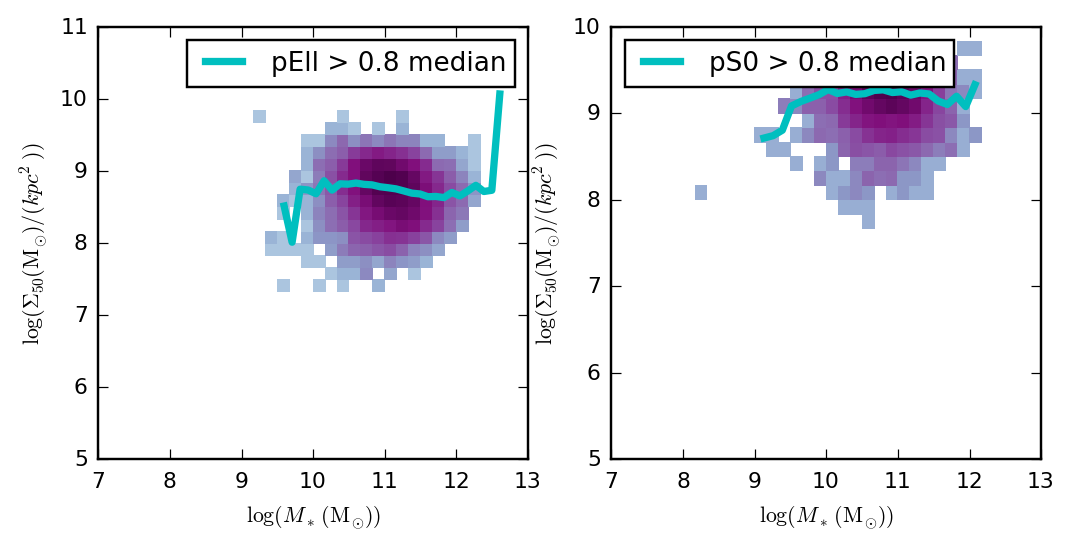

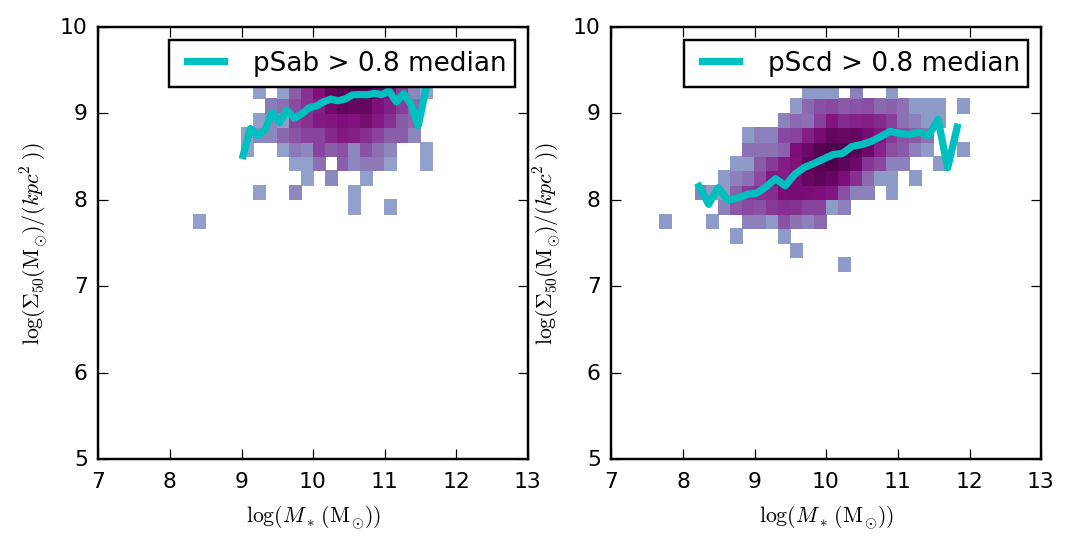

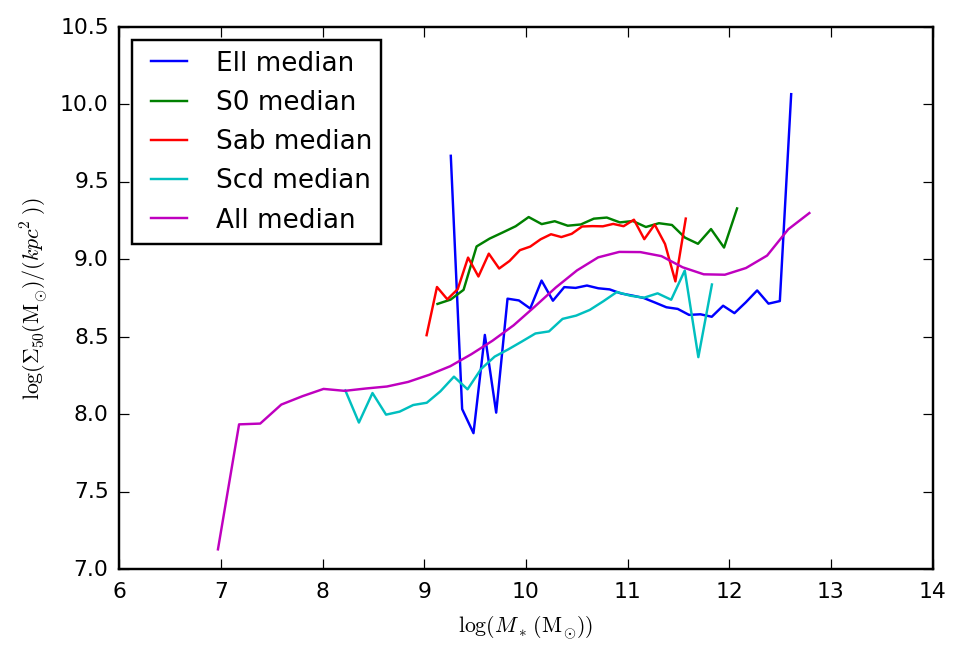

In [34]:
# make some cuts to eliminate bad regimes or catastrophic failures
ipEll = ((pEll>0.8) & (pS0<0.5) & (pSab<0.2) & (pScd<0.2))

# select data within these cuts
sdata1 = sdata[ipEll]; mdata1 = mdata[ipEll]; phot_r1 = phot_r[ipEll] 
mnpdata1 = mnpdata[ipEll]; grm1 = grm[ipEll]; morph1 = morph[ipEll]
mdatag1 = mdatag[ipEll]; mnpdatag1 = mnpdatag[ipEll]
zm1 = sdata1['z']; mpetrom1 = phot_r1['petroMag']; mmeert1 = mdata1['m_tot']
sb501 = sb50[ipEll]; extm1 = mnpdata1['extinction']; kcorr1 = mnpdata1['kcorr']
Rhl1 = mdata1['r_tot']

print "selected", np.size(zm1), " after all cuts..."

# inverse Vmax
vmaxi1 = 1.0/vmaxm[ipEll] 
# luminosity distance in Mpc
d_Lm1 = cosmo.luminosityDistance(zm1)/cosmo.h
d_A1 = cosmo.luminosityDistance(zm1)/cosmo.h/(1.+zm1)
Rhl_kpc1_orig = Rhl1*np.pi*d_A1*1000.0/(180.*3600.)
Rhl_kpc1 = Rhl_kpc1_orig*1.34

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert1 = mmeert1 - 5.0*np.log10(d_Lm1/1e-5) - extm1 + 1.3*zm1 - kcorr1; 
Mpetrom1 = mpetrom1 - 5.0*np.log10(d_Lm1/1e-5) - extm1 + 1.3*zm1 - kcorr1;

# 4.67 is the r-band luminosity in Lsun
Lmeert1 =  0.4*(4.67-(Mmeert1)); Lpetrom1 = 0.4*(4.67-Mpetrom1)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell1 = -.306 + 1.097*grm1 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert1 = Lmeert1 + lMsLrbell1
StellarMass1 = 10.**SMmeert1*cosmo.h**2
surf_density1 = 10**SMmeert1/(np.pi*Rhl_kpc1**2)

# make some cuts to eliminate bad regimes or catastrophic failures
ipS0 = ((pEll<0.5) & (pS0>0.8) & (pSab<0.2) & (pScd<0.2))

# select data within these cuts
sdata2 = sdata[ipS0]; mdata2 = mdata[ipS0]; phot_r2 = phot_r[ipS0] 
mnpdata2 = mnpdata[ipS0]; grm2 = grm[ipS0]; morph2 = morph[ipS0]
mdatag2 = mdatag[ipS0]; mnpdatag2 = mnpdatag[ipS0]
zm2 = sdata2['z']; mpetrom2 = phot_r2['petroMag']; mmeert2 = mdata2['m_tot']
sb502 = sb50[ipS0]; extm2 = mnpdata2['extinction']; kcorr2 = mnpdata2['kcorr']
Rhl2 = mdata2['r_tot']

print "selected", np.size(zm2), " after all cuts..."

# inverse Vmax
vmaxi2 = 1.0/vmaxm[ipS0] 
# luminosity distance in Mpc
d_Lm2 = cosmo.luminosityDistance(zm2)/cosmo.h
d_A2 = cosmo.luminosityDistance(zm2)/cosmo.h/(1.+zm2)
Rhl_kpc2_orig = Rhl2*np.pi*d_A2*1000.0/(180.*3600.)
Rhl_kpc2 = Rhl_kpc2_orig

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert2 = mmeert2 - 5.0*np.log10(d_Lm2/1e-5) - extm2 + 1.3*zm2 - kcorr2; 
Mpetrom2 = mpetrom2 - 5.0*np.log10(d_Lm2/1e-5) - extm2 + 1.3*zm2 - kcorr2;

# 4.67 is the r-band luminosity in Lsun
Lmeert2 =  0.4*(4.67-(Mmeert2)); Lpetrom2 = 0.4*(4.67-Mpetrom2)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell2 = -.306 + 1.097*grm2 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert2 = Lmeert2 + lMsLrbell2
StellarMass2 = 10.**SMmeert2*cosmo.h**2
surf_density2 = 10**SMmeert2/(np.pi*Rhl_kpc2**2)

# make some cuts to eliminate bad regimes or catastrophic failures
ipSab = ((pEll<0.2) & (pS0<0.2) & (pSab>0.8) & (pScd<0.5))

# select data within these cuts
sdata3 = sdata[ipSab]; mdata3 = mdata[ipSab]; phot_r3 = phot_r[ipSab] 
mnpdata3 = mnpdata[ipSab]; grm3 = grm[ipSab]; morph3 = morph[ipSab]
mdatag3 = mdatag[ipSab]; mnpdatag3 = mnpdatag[ipSab]
zm3 = sdata3['z']; mpetrom3 = phot_r3['petroMag']; mmeert3 = mdata3['m_tot']
sb503 = sb50[ipSab]; extm3 = mnpdata3['extinction']; kcorr3 = mnpdata3['kcorr']
Rhl3 = mdata3['r_tot']

print "selected", np.size(zm3), " after all cuts..."

# inverse Vmax
vmaxi3 = 1.0/vmaxm[ipSab] 
# luminosity distance in Mpc
d_Lm3 = cosmo.luminosityDistance(zm3)/cosmo.h
d_A3 = cosmo.luminosityDistance(zm3)/cosmo.h/(1.+zm3)
Rhl_kpc3 = Rhl3*np.pi*d_A3*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert3 = mmeert3 - 5.0*np.log10(d_Lm3/1e-5) - extm3 + 1.3*zm3 - kcorr3; 
Mpetrom3 = mpetrom3 - 5.0*np.log10(d_Lm3/1e-5) - extm3 + 1.3*zm3 - kcorr3;

# 4.67 is the r-band luminosity in Lsun
Lmeert3 =  0.4*(4.67-(Mmeert3)); Lpetrom3 = 0.4*(4.67-Mpetrom3)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell3 = -.306 + 1.097*grm3 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert3 = Lmeert3 + lMsLrbell3
StellarMass3 = 10.**SMmeert3*cosmo.h**2
surf_density3 = 10**SMmeert3/(np.pi*Rhl_kpc3**2)

# make some cuts to eliminate bad regimes or catastrophic failures
ipScd = ((pEll<0.2) & (pS0<0.2) & (pSab<0.5) & (pScd>0.8))

# select data within these cuts
sdata4 = sdata[ipScd]; mdata4 = mdata[ipScd]; phot_r4 = phot_r[ipScd] 
mnpdata4 = mnpdata[ipScd]; grm4 = grm[ipScd]; morph4 = morph[ipScd]
mdatag4 = mdatag[ipScd]; mnpdatag4 = mnpdatag[ipScd]
zm4 = sdata4['z']; mpetrom4 = phot_r4['petroMag']; mmeert4 = mdata4['m_tot']
sb504 = sb50[ipScd]; extm4 = mnpdata4['extinction']; kcorr4 = mnpdata4['kcorr']
Rhl4 = mdata4['r_tot']

print "selected", np.size(zm4), " after all cuts..."

# inverse Vmax
vmaxi4 = 1.0/vmaxm[ipScd] 
# luminosity distance in Mpc
d_Lm4 = cosmo.luminosityDistance(zm4)/cosmo.h
d_A4 = cosmo.luminosityDistance(zm4)/cosmo.h/(1.+zm4)
Rhl_kpc4 = Rhl4*np.pi*d_A4*1000.0/(180.*3600.)

# absolute magnitude in the r-band corrected for extinction, evolution, and k-correction
Mmeert4 = mmeert4 - 5.0*np.log10(d_Lm4/1e-5) - extm4 + 1.3*zm4 - kcorr4; 
Mpetrom4 = mpetrom4 - 5.0*np.log10(d_Lm4/1e-5) - extm4 + 1.3*zm4 - kcorr4;

# 4.67 is the r-band luminosity in Lsun
Lmeert4 =  0.4*(4.67-(Mmeert4)); Lpetrom4 = 0.4*(4.67-Mpetrom4)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLrbell4 = -.306 + 1.097*grm4 - 0.1
# convert to stellar mass. Note that Lmeert and other L quantities below now mean stellar mass
SMmeert4 = Lmeert4 + lMsLrbell4
StellarMass4 = 10.**SMmeert4*cosmo.h**2
surf_density4 = 10**SMmeert4/(np.pi*Rhl_kpc4**2)

fig,ax = plt.subplots(1,2,figsize=(6, 3))
fig.tight_layout()

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]
Sigmalim = [5., 10.]

plot_2d_dist(np.log10(StellarMass1), np.log10(surf_density1), SMlim, Sigmalim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[0])
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(\Sigma_{50} \mathrm{(M_{\odot})}/(kpc^2))$')
from scipy.stats import binned_statistic
cmed11, ibedges11, babins11 = binned_statistic(np.log10(StellarMass1),np.log10(surf_density1),statistic='median',bins=31)
ibins11 = 0.5*(ibedges11[1:] + ibedges11[:-1])
ax[0].plot(ibins11[3:],cmed11[3:],c='c',lw=3.0, label = 'pEll > 0.8 median')
ax[0].legend(loc='best')
plot_2d_dist(np.log10(StellarMass2), np.log10(surf_density2), SMlim, Sigmalim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[1])
ax[1].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[1].set_ylabel(r'$\log(\Sigma_{50} \mathrm{(M_{\odot})}/(kpc^2))$')
from scipy.stats import binned_statistic
cmed22, ibedges22, babins22 = binned_statistic(np.log10(StellarMass2),np.log10(surf_density2),statistic='median',bins=31)
ibins22 = 0.5*(ibedges22[1:] + ibedges22[:-1])
ax[1].plot(ibins22[3:],cmed22[3:],c='c',lw=3.0, label = 'pS0 > 0.8 median')
ax[1].legend(loc='best')

#ax.semilogy()
plt.show()

fig,ax = plt.subplots(1,2,figsize=(6, 3))
fig.tight_layout()

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]

plot_2d_dist(np.log10(StellarMass3), np.log10(surf_density3), SMlim, Sigmalim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[0])
ax[0].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[0].set_ylabel(r'$\log(\Sigma_{50} \mathrm{(M_{\odot})}/(kpc^2))$')
from scipy.stats import binned_statistic
cmed33, ibedges33, babins33 = binned_statistic(np.log10(StellarMass3),np.log10(surf_density3),statistic='median',bins=31)
ibins33 = 0.5*(ibedges33[1:] + ibedges33[:-1])
ax[0].plot(ibins33[3:],cmed33[3:],c='c',lw=3.0, label = 'pSab > 0.8 median')
ax[0].legend(loc='best')
plot_2d_dist(np.log10(StellarMass4), np.log10(surf_density4), SMlim, Sigmalim, weights=None, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[1])
ax[1].set_xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
ax[1].set_ylabel(r'$\log(\Sigma_{50} \mathrm{(M_{\odot})}/(kpc^2))$')
from scipy.stats import binned_statistic
cmed44, ibedges44, babins44 = binned_statistic(np.log10(StellarMass4),np.log10(surf_density4),statistic='median',bins=31)
ibins44 = 0.5*(ibedges44[1:] + ibedges44[:-1])
ax[1].plot(ibins44[3:],cmed44[3:],c='c',lw=3.0, label = 'pScd > 0.8 median')
ax[1].legend(loc='best')
#ax.semilogy()
plt.show()

plt.xlabel(r'$\log(M_*\ \mathrm{(M_{\odot})})$')
plt.ylabel(r'$\log(\Sigma_{50} \mathrm{(M_{\odot})}/(kpc^2))$')
plt.plot(ibins11, cmed11, label='Ell median')
plt.plot(ibins22, cmed22, label='S0 median')
plt.plot(ibins33, cmed33, label='Sab median')
plt.plot(ibins44, cmed44, label='Scd median')
plt.plot(ibinsa, cmeda, label ='All median')
plt.legend(loc='best')
plt.show()


Since we now have to divide by the radius squared the smaller radii galaxies now have larger surface density. Thus, in the surfae density plots, we see that S0 and Sab have higher surface density distribution than Scd and Elliptical galaxies. In addition, there appears to be a bump at $10^{11}$ solar masses.

Question #3

670722 galaxies in Meert et al. sample initially
selected

/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:65: RuntimeWarning: divide by zero encountered in log10
/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:99: RuntimeWarning: divide by zero encountered in log10


 5380  after all cuts...


/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:105: RuntimeWarning: divide by zero encountered in log10


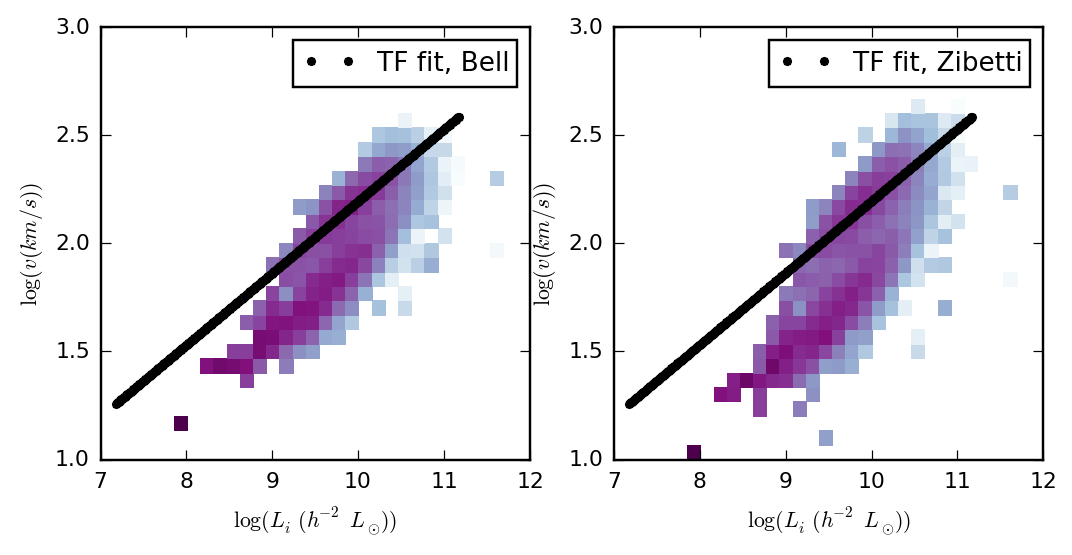

In [43]:

import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph, mdatai, mnpdatai = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 
# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2) & ((pSab>=0.8) | (pScd >=0.8)) & (pS0 < 0.3)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
mdatai = mdatai[ilim]; mnpdatai = mnpdatai[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']; mmeerti = mdatai['m_tot']; extmi = mnpdatai['extinction']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']; kcorri = mnpdatai['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print "selected", np.size(zm), " after all cuts..."

# inverse Vmax
vmaxi = 1.0/vmaxm[ilim] 
# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the i-band corrected for extinction, evolution, and k-correction
Mmeerti = mmeerti - 5.0*np.log10(d_Lm/1e-5) - extmi + 1.3*zm - kcorri; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeerti =  0.4*(4.67-(Mmeerti)); Lpetrom = 0.4*(4.67-Mpetrom)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
lMsLibell = -0.22 + 0.86*grm - 0.15
#lMsLrbell = -.306 + 1.097*grm - 0.1
SMmeert = Lmeerti + lMsLibell
# compute angular diameter distances
r50 = mdatai['r_tot']
d_A = cosmo.luminosityDistance(zm)/cosmo.h/(1.+zm)
R50 = r50*np.pi*d_A*1000.0/(180.*3600.)
Rd = 2.2*R50/1.678
Rout = 2.2*Rd
Li = np.log10(10.**Lmeerti*cosmo.h**2)

#Zibetti fit

lMsLizib = -0.845 + 1.481*grm
SMmeertz = Lmeerti + lMsLizib


from code.plot_utils import plot_2d_dist
plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)
plt.clf()

fig,ax = plt.subplots(1,2,figsize=(6, 3))
fig.tight_layout()

Routlim = [2, 30]

G=4.302e-6 #kpc (km/s)^2 /M_sun
Lindex = np.arange(7.5, 11.5, 0.01)
Mmeertindex = -(Lindex/0.4-4.67)
v = np.sqrt(G*10**SMmeert/Rout)
vzib = np.sqrt(G*10**SMmeertz/Rout)

lvfit = 2.120 +(-0.133)*(Mmeertindex - -20.558)
lvfitz = 2.120 +(-0.133)*(Mmeertindex - -20.558)
Lh = np.log10(10.**Lindex*cosmo.h**2)

#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]
plot_2d_dist(Li, np.log10(v), [7.4, 12.], [1, 3], weights=vmaxi, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[0])
ax[0].set_xlabel(r'$\log(L_i\ (h^{-2}\, L_{\odot}))$');
ax[0].set_ylabel(r'$\log(v (km/s))$')
ax[0].plot(Lh, lvfit, '.k', label='TF fit, Bell')
ax[0].set_ylim([1, 3])
ax[0].legend(loc='best')
plot_2d_dist(Li, np.log10(vzib), [7.4, 12.], [1, 3], weights=vmaxi, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax[1])
ax[1].set_xlabel(r'$\log(L_i\ (h^{-2}\, L_{\odot}))$');
ax[1].set_ylabel(r'$\log(v (km/s))$')
ax[1].plot(Lh, lvfitz, '.k', label='TF fit, Zibetti')
ax[1].set_ylim([1, 3])
ax[1].legend(loc='best')
#ax.semilogy()
plt.show()



Both synthetic TF relation seems slightly off from the true TF relation from Reyes 2011. However, the Bell calibration seems to match better than the Zibetti one. There is a slight offset on the rotation velocity. Based from this, I would interpret my results as there must be a substantial amount of missing mass (either due to a bad mass-to-light ratio calibration or dark matter, perhaps) or the radius of the objects are much smaller than I calculated. In general, the two calibration distributions still generally agree so I'd say the results are fairly robust.

670722 galaxies in Meert et al. sample initially
selected 12272  after all cuts...


/home/tangq/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:63: RuntimeWarning: invalid value encountered in sqrt


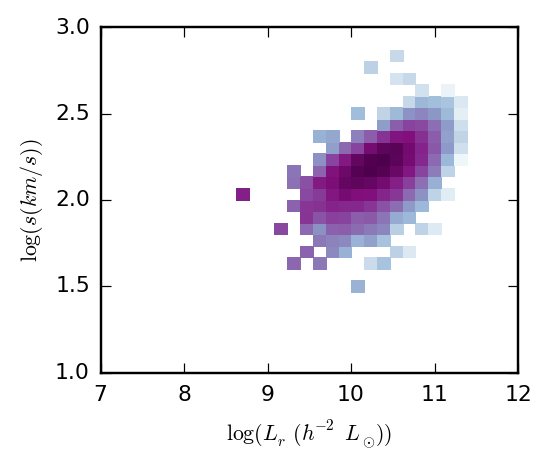

In [46]:

import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph, mdatai, mnpdatai = read_meert_catalog(phot_type=3)

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# prepare preliminary quantities
size = phot_r['petroR50']; extm = mnpdata['extinction']
# correct the Petrosian magnitude for extinction
mrm = phot_r['petroMag'] - extm
# compute surface brightnesses
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
# and extinction corrected colors
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']
# pre-computed Vmax volume available in the catalog
vmaxm = mnpdata['Vmax'];
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 
# make some cuts to eliminate bad regimes or catastrophic failures
ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2) & ((pSab<0.3) & (pScd < 0.3)) & (pEll > 0.8) & (pS0 < 0.3)

# select data within these cuts
sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]; morph = morph[ilim]
mdatag = mdatag[ilim]; mnpdatag = mnpdatag[ilim]
mdatai = mdatai[ilim]; mnpdatai = mnpdatai[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']; mmeerti = mdatai['m_tot']; extmi = mnpdatai['extinction']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']; kcorri = mnpdatai['kcorr']

# concentration of light, Sersic index, image axis ratio b/a
cr = phot_r['petroR90']/phot_r['petroR50']; nser = mdata['n_bulge']; ba = mdata['ba_tot']; 

print "selected", np.size(zm), " after all cuts..."

# inverse Vmax
vmaxi = 1.0/vmaxm[ilim] 
# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# absolute magnitude in the i-band corrected for extinction, evolution, and k-correction
Mmeertr = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# 4.67 is the r-band luminosity in Lsun
Lmeertr =  0.4*(4.67-(Mmeertr)); Lpetrom = 0.4*(4.67-Mpetrom)
# convert to stellar mass using the M/L conversion from Bell et al. 2003 for the Chabrier IMF
#lMsLibell = -0.22 + 0.86*grm - 0.15
lMsLrbell = -.306 + 1.097*grm - 0.1
SMmeertr = Lmeertr + lMsLrbell
# compute angular diameter distances
r50r = mdata['r_tot']
d_A = cosmo.luminosityDistance(zm)/cosmo.h/(1.+zm)
R50r = r50r*np.pi*d_A*1000.0/(180.*3600.)
s = np.sqrt(G*(10**SMmeertr)/(4*R50r))
Lr = np.log10(10.**Lmeertr*cosmo.h**2)

fig, ax = plt.subplots(1,figsize=(3, 2.5))
fig.tight_layout()


#ax.set_title(r'$\mathrm{the\ entire\ sample:}\ M_r<%.1f,\ d_L<%.1f$'%(Mlim,Dmax), fontsize=10)

#ablim = [0.,1.]
plot_2d_dist(Lr, np.log10(s), [7.4, 12.], [1, 3], weights=vmaxi, nxbins=31, nybins=31, xlabel='Stellar Mass', ylabel=r'$R_50$', fig_setup=ax)
ax.set_xlabel(r'$\log(L_r\ (h^{-2}\, L_{\odot}))$');
ax.set_ylabel(r'$\log(s (km/s))$')
#ax.semilogy()
plt.show()

Comparing the median and scatter, this seems to fit quite nicely. (Sorry, I couldn't overlay the SDSS median/scatter on top of this plot, apologies!) It seems like the power law relation also nicely describes this distribution. I would argue that there does not seem to be a substantial amount of dark matter within $R_{50}$ in elliptical galaxies. This is because the rotational dispersion seems to follow virial theorem quite well and the masses do match up. There's no "missing mass" we'd expect if there were dark matter, i.e. the graph has no offset from the relation. The form of FJ relation is that $L \propto \sigma^4$ for spheroidal galaxies while TF relation is $L_f \propto W ^\eta$ for spiral galaxies where $W$ is the maximum velocity from the line width of the hydrogen line emission and $\eta$ is ~3-4. FJ looks at velocity dispersion and comes mainly from Virial Theorem while TF looks at maximum velocity and comes from equating gravity and centripetal force and using brightness formulas. There are more debates about the exact slope of TF relation due to measurement difficulties while FJ relation shows little scatter.